In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
import pandas as pd
import PIL.Image
import collections

from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
all_info = pd.read_csv("/content/drive/MyDrive/GitHub_Projects/plane_variants/img/all_info.csv")
all_info.sample(10)

,long_model,airline,photo_date,uploaded_date,location,uploader,photo_link,download_path,model,variant
11528,Boeing 737-823,American Airlines,Photo date: 2021-05-24,Uploaded: 2021-06-06,Location: Cleveland-Hopkins Int'l Airport - KC...,By: Alex Crail,cdn.jetphotos.com/400/5/37213_1621910909.jpg,./img/B737/cdn.jetphotos.com-400-5-37213_16219...,B737,823
11449,Boeing 737-89L,Air China,Photo date: 2019-02-11,Uploaded: 2021-06-07,"Location: Beijing Capital - ZBAA, China",By: Dave Zhang,cdn.jetphotos.com/400/5/85492_1621953399.jpg,./img/B737/cdn.jetphotos.com-400-5-85492_16219...,B737,89L
2049,Airbus A320-271N,Wizz Air,Photo date: 2021-05-08,Uploaded: 2021-05-23,"Location: Milano Malpensa - LIMC, Italy",By: Medolago Manuel,cdn.jetphotos.com/400/5/91321_1620970157.jpg,./img/A320/cdn.jetphotos.com-400-5-91321_16209...,A320,271N
18440,Boeing 787-9 Dreamliner,Turkish Airlines,Photo date: 2021-05-02,Uploaded: 2021-05-14,"Location: Vancouver Int'l Airport - CYVR, Canada",By: Chung Kwok,cdn.jetphotos.com/400/6/10604_1620141098.jpg,./img/B787/cdn.jetphotos.com-400-6-10604_16201...,B787,9
12024,Boeing 737-81B,China Southern Airlines,Photo date: 2021-05-17,Uploaded: 2021-06-04,"Location: Wuhan Tianhe - ZHHH, China",By: nibrage,cdn.jetphotos.com/400/5/14205_1621603228.jpg,./img/B737/cdn.jetphotos.com-400-5-14205_16216...,B737,81B
6520,Airbus A350-941,China Airlines,Photo date: 2019-10-22,Uploaded: 2021-06-04,Location: Sydney Kingsford Smith Int'l Airport...,By: M.T,cdn.jetphotos.com/400/5/26348_1621652442.jpg,./img/A350/cdn.jetphotos.com-400-5-26348_16216...,A350,941
11818,Boeing 737-8Q8,Shanghai Airlines,Photo date: 2021-05-01,Uploaded: 2021-06-05,"Location: Shanghai Pudong - ZSPD, China",By: BobH,cdn.jetphotos.com/400/6/97706_1621742167.jpg,./img/B737/cdn.jetphotos.com-400-6-97706_16217...,B737,8Q8
56,Airbus A320-214,easyJet Europe,Photo date: 2021-05-29,Uploaded: 2021-06-15,"Location: Tenerife Sur-Reina Sofía - GCTS, Spain",By: Román A. Pérez,cdn.jetphotos.com/400/6/83463_1622615311.jpg,./img/A320/cdn.jetphotos.com-400-6-83463_16226...,A320,214
4917,Airbus A340-313,Lufthansa,Photo date: 2021-02-14,Uploaded: 2021-03-08,"Location: München Franz Josef Strauß - EDDM, G...",By: Picturefreaks,cdn.jetphotos.com/400/6/62172_1614532635.jpg,./img/A340/cdn.jetphotos.com-400-6-62172_16145...,A340,313
11456,Boeing 737-7H4,Southwest Airlines,Photo date: 2021-05-08,Uploaded: 2021-06-07,Location: Detroit Metropolitan Wayne County - ...,By: Brady Noble,cdn.jetphotos.com/400/6/35747_1621950056.jpg,./img/B737/cdn.jetphotos.com-400-6-35747_16219...,B737,7H4


In [6]:
all_info.loc[:, "download_path"] = all_info.download_path.str.replace("\\./", "/content/drive/MyDrive/GitHub_Projects/plane_variants/")
all_info_rows = all_info.shape[0]
np.random.seed(10)
# all_info["purpose"] = np.random.choice(["train", "test", "validation"], size=all_info_rows, replace=True, p=[0.64, 0.16, 0.2])
a380vb787 = all_info.loc[all_info.model.isin(["A380", "B787"])].reset_index()
a380vb787.head()

,index,long_model,airline,photo_date,uploaded_date,location,uploader,photo_link,download_path,model,variant
0,8320,Airbus A380-861,Emirates,Photo date: 2021-05-30,Uploaded: 2021-06-15,Location: Manchester Ringway Int'l Airport - E...,By: Paul Spijkers,cdn.jetphotos.com/400/5/68077_1622647548.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,861
1,8321,Airbus A380-861,Emirates,Photo date: 2021-04-10,Uploaded: 2021-06-15,"Location: Guangzhou Baiyun Airport - ZGGG, China",By: ChaleLu,cdn.jetphotos.com/400/6/75937_1622641760.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,861
2,8322,Airbus A380-841,China Southern Airlines,Photo date: 2021-05-19,Uploaded: 2021-06-15,"Location: Guangzhou Baiyun Airport - ZGGG, China",By: Fang Xiaoyu,cdn.jetphotos.com/400/6/74070_1622628386.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,841
3,8323,Airbus A380-841,Singapore Airlines,Photo date: 2019-09-02,Uploaded: 2021-06-15,"Location: Zurich-Kloten Airport - LSZH, Switze...",By: Nguyen Huy Bao,cdn.jetphotos.com/400/5/32090_1622625012.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,841
4,8324,Airbus A380-841,British Airways,Photo date: 2019-04-19,Uploaded: 2021-06-15,"Location: London Heathrow Int'l - EGLL, United...",By: Simon Fewkes,cdn.jetphotos.com/400/5/60639_1622620557.jpg,/content/drive/MyDrive/GitHub_Projects/plane_v...,A380,841


# Loading data

In [7]:
def prep_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) * 2
    return img

a380vb787_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_fn)
IMG_SIZE = (225, 400)

a380vb787_dataset = a380vb787_datagen.flow_from_dataframe(
    dataframe=a380vb787,
    directory=None,
    x_col="download_path",
    y_col="model",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=1234)

Found 4160 validated image filenames belonging to 2 classes.


In [8]:
print(type(a380vb787_dataset[0])) # tuple of images and label
print(type(a380vb787_dataset[0][0])) # tuple of images, for one batch
print(type(a380vb787_dataset[0][1])) # tuple of labels, for one batch

<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
print(a380vb787_dataset[0][0].shape)
print(a380vb787_dataset[0][1].shape)

(32, 225, 400, 3)
(32,)


In [10]:
a380vb787_dataset[0][1]

array([1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

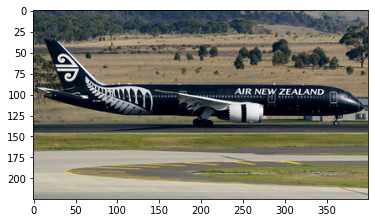

In [11]:
plt.imshow(((a380vb787_dataset[0][0][0,:,:,:])+1)/2)
plt.show()

# Loading model

In [12]:
model = keras.models.load_model('/content/drive/MyDrive/GitHub_Projects/plane_variants/model/a380vb787')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [13]:
!pip install shap

     |████████████████████████████████| 358kB 4.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=48f1a11048ee27d31a1e094821862a12e48fbf3331540f408a3be22249413fd3
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [14]:
import json
import shap
import tensorflow as tf

In [15]:
X = a380vb787_dataset[1][0]
y = a380vb787_dataset[1][1]
print(type(X))
print(X.shape)
print(X[0].shape)

<class 'numpy.ndarray'>
(32, 225, 400, 3)
(225, 400, 3)


In [16]:
print(y)

[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 0. 1.]


In [17]:
preprocess_input = prep_fn
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [18]:
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

def f(X):
    tmp = X.copy()
    x = preprocess_input(tmp)
    return model(tmp, training=False)

explainer = shap.Explainer(f, masker, output_names=None)

In [19]:
shap_values = explainer(X[0:5], max_evals=500, batch_size=32, outputs=shap.Explanation.argsort.flip[:1])

Partition explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 3/5 [01:53<00:54, 27.16s/it]

Partition explainer:  80%|████████  | 4/5 [02:47<00:35, 35.32s/it]

Partition explainer: 100%|██████████| 5/5 [03:44<00:00, 41.69s/it]

Partition explainer: 6it [04:38, 46.43s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


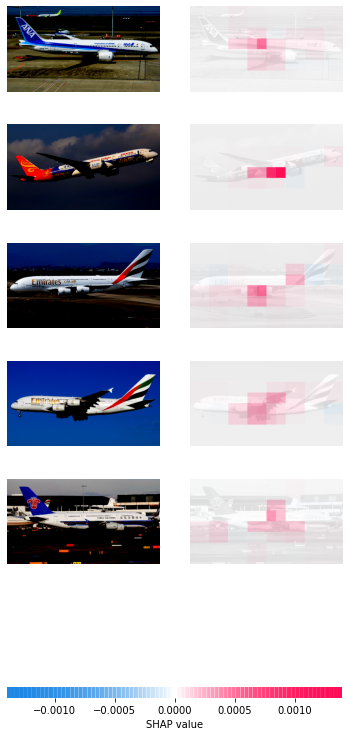

In [20]:
shap.image_plot(shap_values)